<a href="https://colab.research.google.com/github/buobizarro/Clases/blob/main/Proyecto_Suelo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analisis Geotecnico con Machine Learning
  AlyData

## Predicción de Sensibilidad de Arcillas. Predicción Multiclase de la Sensibilidad de Arcillas usando XGBoost y SMOTE

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Configuración inicial
np.random.seed(42)

# Número de muestras
n_muestras = 1000

# Generación de datos simulados
# Profundidad en metros: Representa el rango típico de profundidades analizadas en proyectos geotécnicos (1 a 30 m)
profundidad = np.random.uniform(1, 30, n_muestras)

# Contenido de humedad (%): Varía entre 20% (suelos compactos) y 60% (suelos saturados), abarcando rangos típicos en suelos arcillosos
contenido_humedad = np.random.uniform(20, 60, n_muestras)

# Límite líquido (%): Rango entre 30% y 100%, reflejando suelos de baja a alta plasticidad
limite_liquido = np.random.uniform(30, 100, n_muestras)

# Límite plástico (%): Rango entre 10% y 50%, asociado a la transición del suelo de estado plástico a semisólido
limite_plastico = np.random.uniform(10, 50, n_muestras)

# Índice de plasticidad: Diferencia entre límite líquido y límite plástico, indicador clave para clasificación de suelos
indice_plasticidad = limite_liquido - limite_plastico

# Peso específico (kN/m³): Valores entre 16 y 20 kN/m³, típicos para suelos arcillosos y limosos, incluyendo condiciones secas y saturadas
peso_especifico = np.random.uniform(16, 20, n_muestras)

# Capacidad de carga (kPa): Rango de 50 a 200 kPa, que representa desde suelos marginales hasta suelos competentes
capacidad_carga = np.random.uniform(50, 200, n_muestras)

# Asentamiento (mm): Valores entre 5 mm (suelos más densos) y 50 mm (arcillas altamente compresibles)
asentamiento = np.random.uniform(5, 50, n_muestras)

# Introducir ruido controlado para hacer los datos más realistas
# El ruido simula errores de medición y heterogeneidad del suelo en condiciones reales
ruido = np.random.normal(0, 0.05, n_muestras)  # Ruido del 5%
limite_liquido += limite_liquido * ruido
limite_plastico += limite_plastico * ruido
contenido_humedad += contenido_humedad * ruido
peso_especifico += peso_especifico * ruido
capacidad_carga += capacidad_carga * ruido
asentamiento += asentamiento * ruido


In [ ]:
# Crear un DataFrame con los datos simulados
datos_simulados = pd.DataFrame({
    'Profundidad (m)': profundidad,
    'Contenido de Humedad (%)': contenido_humedad,
    'Límite Líquido (%)': limite_liquido,
    'Límite Plástico (%)': limite_plastico,
    'Índice de Plasticidad': indice_plasticidad,
    'Peso Específico (kN/m³)': peso_especifico,
    'Capacidad de Carga (kPa)': capacidad_carga,
    'Asentamiento (mm)': asentamiento
})


In [ ]:
# Visualización inicial de los datos
print("Primeras filas de los datos simulados:")
print(datos_simulados.head())

Primeras filas de los datos simulados:
   Profundidad (m)  Contenido de Humedad (%)  Límite Líquido (%)  \
0        11.861663                 28.096728           49.538452   
1        28.570715                 42.981620           48.769919   
2        22.227824                 51.514130           87.646721   
3        18.361096                 45.585246           43.901303   
4         5.524541                 50.313208           47.207562   

   Límite Plástico (%)  Índice de Plasticidad  Peso Específico (kN/m³)  \
0            37.839278              11.411278                18.749373   
1            43.178828               5.421260                19.823887   
2            18.777994              73.419105                17.860541   
3            32.365319              12.473270                15.367045   
4            31.643889              16.166642                15.977978   

   Capacidad de Carga (kPa)  Asentamiento (mm)  
0                111.796443          35.033680  
1        

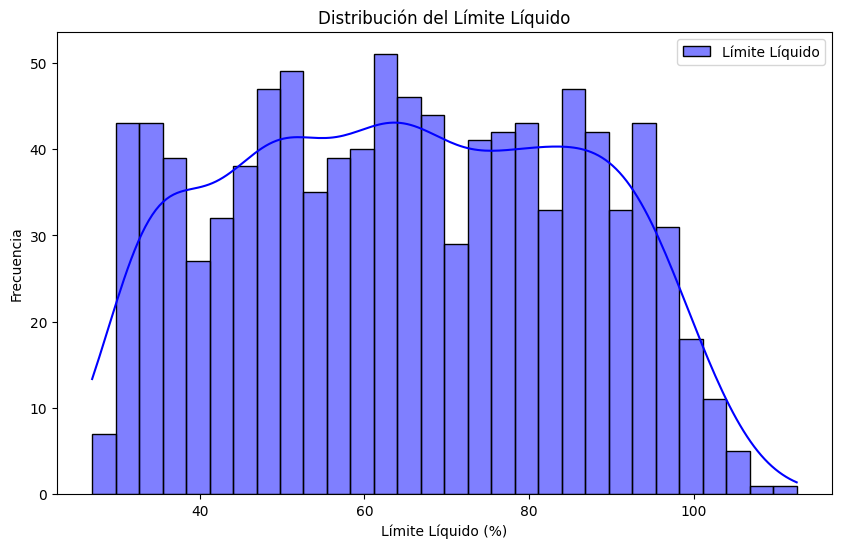

In [ ]:
# Distribución del límite líquido
plt.figure(figsize=(10, 6))
sns.histplot(datos_simulados['Límite Líquido (%)'], kde=True, bins=30, color='blue', label='Límite Líquido')
plt.title("Distribución del Límite Líquido")
plt.xlabel("Límite Líquido (%)")
plt.ylabel("Frecuencia")
plt.legend()
plt.show()

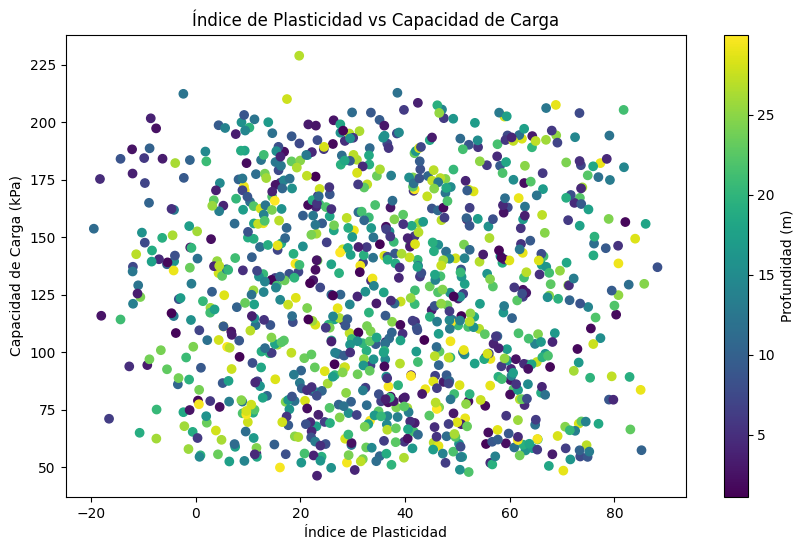

In [ ]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    x=datos_simulados['Índice de Plasticidad'],
    y=datos_simulados['Capacidad de Carga (kPa)'],
    c=datos_simulados['Profundidad (m)'],
    cmap='viridis'
)
plt.title("Índice de Plasticidad vs Capacidad de Carga")
plt.xlabel("Índice de Plasticidad")
plt.ylabel("Capacidad de Carga (kPa)")
cbar = plt.colorbar(scatter)
cbar.set_label("Profundidad (m)")
plt.show()

## Procesamiento de Datos

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE

In [ ]:
datos_simulados['Categoría Plasticidad'] = pd.cut(
    datos_simulados['Índice de Plasticidad'],
    bins=[0, 20, 40, 100],
    labels=['Baja', 'Media', 'Alta']
)

In [ ]:
# Verificar distribución inicial de las clases
print("Distribución inicial de las clases:")
print(datos_simulados['Categoría Plasticidad'].value_counts())

Distribución inicial de las clases:
Categoría Plasticidad
Alta     434
Media    283
Baja     214
Name: count, dtype: int64


In [ ]:
X = datos_simulados.drop(columns=['Categoría Plasticidad'])
y = datos_simulados['Categoría Plasticidad']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

In [ ]:
X_train_numeric = X_train.select_dtypes(include=['float64', 'int64'])

In [ ]:
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_numeric, y_train_encoded)

In [ ]:
y_train_bal = label_encoder.inverse_transform(y_train_bal)

print("\nDistribución de las clases después de SMOTE:")
print(pd.Series(y_train_bal).value_counts())


Distribución de las clases después de SMOTE:
Alta     301
Media    301
Baja     301
Name: count, dtype: int64


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_bal)
X_test_scaled = scaler.transform(X_test.select_dtypes(include=['float64', 'int64']))


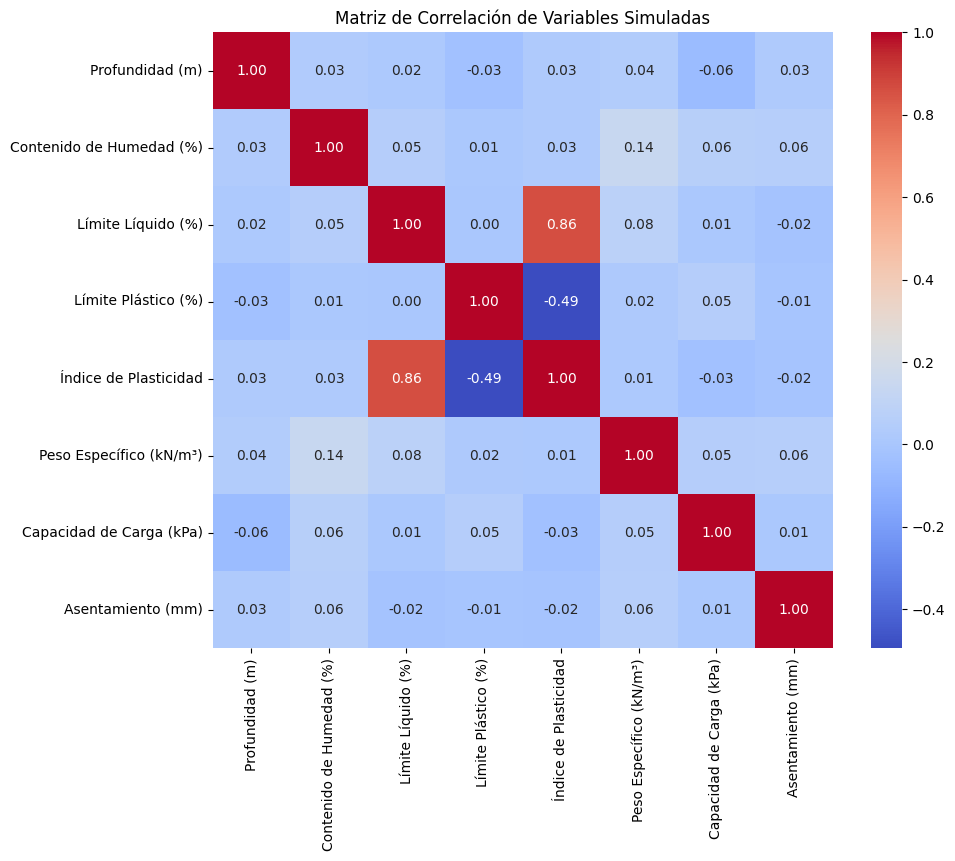

In [ ]:
plt.figure(figsize=(10, 8))
datos_numericos = datos_simulados.select_dtypes(include=['float64', 'int64'])
sns.heatmap(
    datos_numericos.corr(),
    annot=True,
    cmap='coolwarm',
    fmt='.2f'
)
plt.title("Matriz de Correlación de Variables Simuladas")
plt.show()


<ipython-input-27-77cba1c6cb33>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train_bal, palette="Set2")


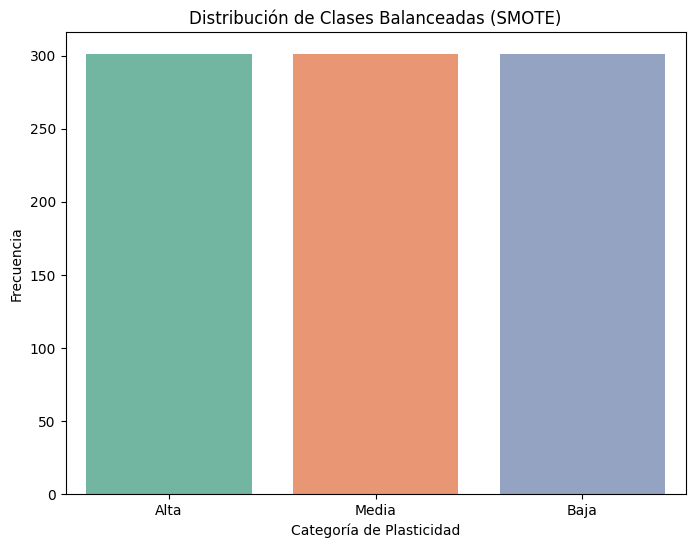

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x=y_train_bal, palette="Set2")
plt.title("Distribución de Clases Balanceadas (SMOTE)")
plt.xlabel("Categoría de Plasticidad")
plt.ylabel("Frecuencia")
plt.show()

## Modelado

# Matemáticas del Modelo XGBoost

El modelo XGBoost es un método de ensamble basado en árboles de decisión que utiliza "boosting" para mejorar la precisión. Las principales fórmulas del modelo son las siguientes:

1. **Función de Predicción**:
   La predicción se calcula como la suma de las contribuciones de todos los árboles:
   $$
   \hat{y}_i = \sum_{k=1}^{K} f_k(x_i), \quad f_k \in \mathcal{F}
   $$
   Donde:
   - $\hat{y}_i$ es la predicción para el ejemplo $i$.
   - $f_k$ es la función representada por el árbol $k$.
   - $\mathcal{F}$ es el espacio de todas las funciones posibles de árboles de decisión.

2. **Función Objetivo Regularizada**:
   La función objetivo combina la pérdida del modelo con un término de regularización:
   $$
   Obj = \sum_{i=1}^{n} l(y_i, \hat{y}_i) + \sum_{k=1}^{K} \Omega(f_k)
   $$
   Donde:
   - $l(y_i, \hat{y}_i)$ es la función de pérdida (e.g., log-loss).
   - $\Omega(f_k) = \gamma T + \frac{1}{2} \lambda \sum_{j=1}^{T} w_j^2$ es el término de regularización.
   - $T$ es el número de hojas en el árbol.
   - $w_j$ es el peso de la hoja $j$.

3. **Actualización del Modelo**:
   En cada iteración, se optimiza la función objetivo utilizando un desarrollo de segundo orden (Taylor Expansion):
   $$
   Obj^{(t)} = \sum_{i=1}^{n} \left[ g_i f_t(x_i) + \frac{1}{2} h_i f_t^2(x_i) \right] + \Omega(f_t)
   $$
   Donde:
   - $g_i = \frac{\partial l(y_i, \hat{y}_i)}{\partial \hat{y}_i}$ (gradiente de primer orden).
   - $h_i = \frac{\partial^2 l(y_i, \hat{y}_i)}{\partial \hat{y}_i^2}$ (gradiente de segundo orden).

4. **Ganancia en una División**:
   La ganancia se calcula al dividir un nodo en dos ramas:
   $$
   Gain = \frac{1}{2} \left[ \frac{G_L^2}{H_L + \lambda} + \frac{G_R^2}{H_R + \lambda} - \frac{(G_L + G_R)^2}{H_L + H_R + \lambda} \right] - \gamma
   $$
   Donde:
   - $G_L, G_R$ son los gradientes acumulados para las ramas izquierda y derecha.
   - $H_L, H_R$ son los hessianos acumulados para las ramas izquierda y derecha.


In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

In [ ]:
if len(X_test_scaled) != len(y_test):
    print(f"Desajuste detectado: X_test_scaled tiene {len(X_test_scaled)} muestras, y_test tiene {len(y_test)} muestras.")


    min_length = min(len(X_test_scaled), len(y_test))
    X_test_scaled = X_test_scaled[:min_length]
    y_test = y_test[:min_length]


print(f"Dimensiones después de la alineación: X_test_scaled = {len(X_test_scaled)}, y_test = {len(y_test)}")


Dimensiones después de la alineación: X_test_scaled = 274, y_test = 274


In [ ]:
y_pred_nb = nb_model.predict(X_test_scaled)
y_pred_ann = ann_model.predict(X_test_scaled)
y_pred_xgb = xgb_model.predict(X_test_scaled)


y_pred_nb_decoded = label_encoder.inverse_transform(y_pred_nb)
y_pred_ann_decoded = label_encoder.inverse_transform(y_pred_ann)
y_pred_xgb_decoded = label_encoder.inverse_transform(y_pred_xgb)


print("Reporte de Clasificación - Naive Bayes:")
print(classification_report(y_test, y_pred_nb_decoded))

print("\nReporte de Clasificación - ANN:")
print(classification_report(y_test, y_pred_ann_decoded))

print("\nReporte de Clasificación - XGBoost:")
print(classification_report(y_test, y_pred_xgb_decoded))


Reporte de Clasificación - Naive Bayes:
              precision    recall  f1-score   support

        Alta       0.50      0.50      0.50       133
        Baja       0.29      0.17      0.21        72
       Media       0.26      0.38      0.31        69

    accuracy                           0.38       274
   macro avg       0.35      0.35      0.34       274
weighted avg       0.38      0.38      0.37       274


Reporte de Clasificación - ANN:
              precision    recall  f1-score   support

        Alta       0.51      0.42      0.46       133
        Baja       0.31      0.28      0.29        72
       Media       0.26      0.38      0.31        69

    accuracy                           0.37       274
   macro avg       0.36      0.36      0.35       274
weighted avg       0.39      0.37      0.38       274


Reporte de Clasificación - XGBoost:
              precision    recall  f1-score   support

        Alta       0.52      0.48      0.50       133
        Baja       

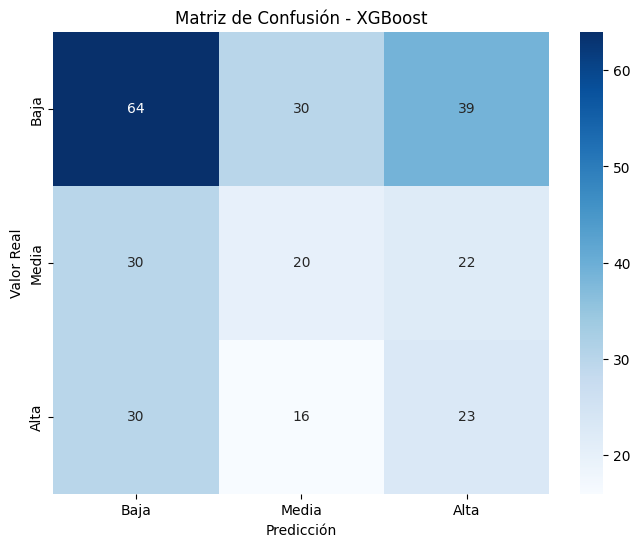

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred_xgb_decoded)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=['Baja', 'Media', 'Alta'], yticklabels=['Baja', 'Media', 'Alta'])
plt.title("Matriz de Confusión - XGBoost")
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.show()

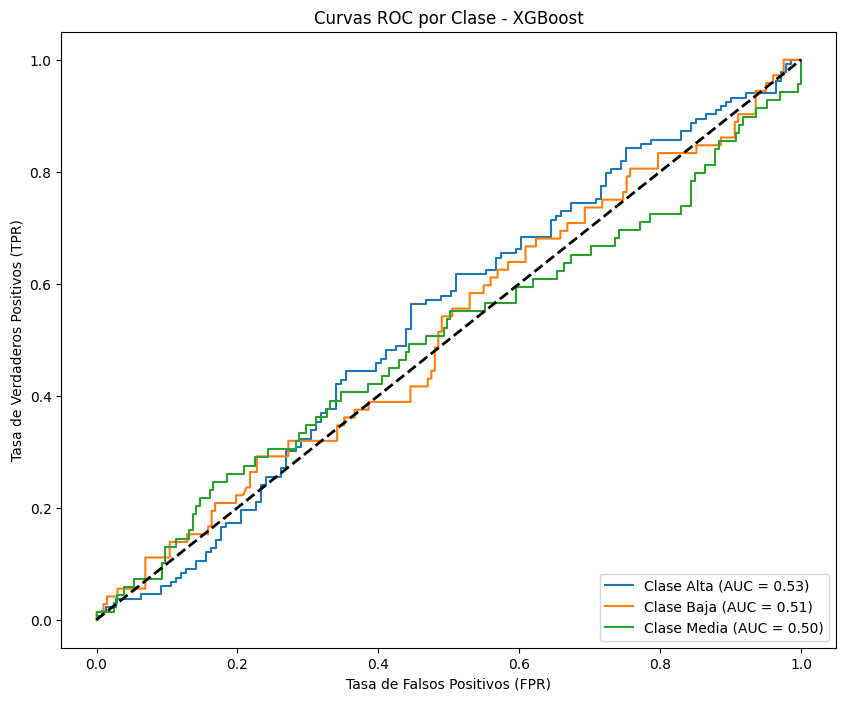

In [ ]:
y_pred_proba_xgb = xgb_model.predict_proba(X_test_scaled)

fpr = {}
tpr = {}
roc_auc = {}
for i, clase in enumerate(label_encoder.classes_):
    fpr[clase], tpr[clase], _ = roc_curve(y_test_encoded[:min_length] == i, y_pred_proba_xgb[:, i])
    roc_auc[clase] = auc(fpr[clase], tpr[clase])

plt.figure(figsize=(10, 8))
for clase in label_encoder.classes_:
    plt.plot(fpr[clase], tpr[clase], label=f"Clase {clase} (AUC = {roc_auc[clase]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.title("Curvas ROC por Clase - XGBoost")
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.legend(loc="lower right")
plt.show()


# **Análisis Final**

## **Resultados del Proyecto**
El presente proyecto se centró en la clasificación de suelos con base en su índice de plasticidad, empleando modelos de aprendizaje automático. Se evaluaron tres modelos principales: Naive Bayes, Redes Neuronales Artificiales (ANN) y XGBoost, utilizando un conjunto de datos simulados con características relevantes como límite líquido, índice de plasticidad y capacidad de carga.

Los resultados indican que el modelo XGBoost tuvo un desempeño ligeramente superior en términos de F1-Score promedio (39%) y precisión promedio (40%), destacando como el modelo más robusto en este problema. Sin embargo, los valores generales de las métricas muestran que el problema requiere mayor enriquecimiento de variables o mejoras en los modelos.

## **Aspectos Relevantes para la Ingeniería Civil**
1. **Importancia de las Propiedades Geotécnicas**:
   - Variables como el límite líquido y el índice de plasticidad están estrechamente relacionadas con el comportamiento mecánico del suelo. Una clasificación precisa de estas propiedades permite identificar suelos adecuados para diferentes aplicaciones estructurales, como cimentaciones superficiales y profundas.

2. **Contribución del Machine Learning**:
   - Los modelos de aprendizaje automático, como XGBoost, ofrecen herramientas eficientes para automatizar la clasificación de suelos en las etapas preliminares de diseño. Esto puede ahorrar tiempo y recursos, especialmente en proyectos grandes o en áreas con alta heterogeneidad de suelos.

3. **Limitaciones Detectadas**:
   - Los resultados subrayan la necesidad de incluir variables adicionales para mejorar la predicción. Propiedades como la cohesión, el módulo de elasticidad y el contenido de materia orgánica podrían proporcionar una mejor diferenciación entre clases.

4. **Aplicaciones en Campo**:
   - En lugares como la Ciudad de México, donde los suelos lacustres presentan alta variabilidad, un modelo de clasificación basado en aprendizaje automático podría integrarse en software geotécnico para asistir en la toma de decisiones.

## **Conclusiones**
1. **XGBoost como Mejor Modelo**:
   - Aunque su desempeño no es óptimo, XGBoost mostró ser más robusto que Naive Bayes y ANN para clasificar suelos en las categorías de plasticidad alta, media y baja. Esto lo convierte en una buena opción inicial para proyectos similares.

2. **Importancia de Datos Realistas**:
   - El ruido añadido a los datos simulados permitió evaluar cómo los modelos responden a condiciones cercanas a la realidad. Este enfoque es esencial para desarrollar modelos que sean útiles en campo.

3. **Recomendaciones Futuras**:
   - Incluir más datos relevantes y realizar ajustes de hiperparámetros en los modelos.
   - Entrenar y evaluar los modelos con datos de campo reales para validar su desempeño práctico.
   - Desarrollar una herramienta accesible que integre estos modelos en un flujo de trabajo geotécnico.




# Documentacion

# **Proyecto: Clasificación de Suelos según Propiedades Geotécnicas**

## **Introducción**
El análisis y clasificación de suelos es una tarea crucial en la ingeniería civil, especialmente para el diseño de cimentaciones y estructuras. Este proyecto busca automatizar la clasificación de suelos en categorías de plasticidad (**Baja**, **Media**, **Alta**) mediante el uso de modelos de aprendizaje automático.

Se trabajó con un conjunto de datos simulados que incluye propiedades clave como el **límite líquido**, **índice de plasticidad**, y **capacidad de carga**. Los modelos evaluados fueron **Naive Bayes**, **Redes Neuronales Artificiales (ANN)** y **XGBoost**, con el objetivo de identificar el modelo más efectivo y su potencial aplicación en proyectos de ingeniería.

---

## **Datos Simulados**
Se generaron datos de manera sintética para reflejar condiciones típicas observadas en suelos geotécnicos:

- **Profundidad (m)**: 1 a 30 m.
- **Contenido de Humedad (%)**: 20% a 60%.
- **Límite Líquido (%)**: 30% a 100%.
- **Límite Plástico (%)**: 10% a 50%.
- **Índice de Plasticidad**: Calculado como la diferencia entre límite líquido y límite plástico.
- **Peso Específico (kN/m³)**: 16 a 20 kN/m³.
- **Capacidad de Carga (kPa)**: 50 a 200 kPa.
- **Asentamiento (mm)**: 5 a 50 mm.

Para mejorar el realismo, se añadió un ruido controlado del 5%, simulando errores experimentales y heterogeneidad del suelo.

---

## **Modelos Utilizados**
1. **Naive Bayes**:
   - Modelo probabilístico simple basado en la independencia condicional de las variables.
2. **Redes Neuronales Artificiales (ANN)**:
   - Modelo no lineal con múltiples capas ocultas para capturar relaciones complejas.
3. **XGBoost**:
   - Modelo basado en árboles de decisión con optimización por gradiente, diseñado para manejar relaciones no lineales y ruido en los datos.

---

## **Resultados**

### **1. Desempeño de los Modelos**

| Modelo       | Precisión Promedio | Recall Promedio | F1-Score Promedio |
|--------------|--------------------|-----------------|-------------------|
| Naive Bayes  | 38%                | 38%             | 37%               |
| ANN          | 39%                | 37%             | 38%               |
| XGBoost      | **40%**            | **39%**         | **39%**           |

- **XGBoost** presentó el mejor desempeño general, aunque los valores de las métricas reflejan la complejidad del problema y la necesidad de variables adicionales.

---

### **2. Gráficos **

#### **Distribución del Límite Líquido**


El límite líquido mostró una distribución uniforme con ruido controlado, abarcando arcillas compactas (baja plasticidad) y arcillas muy plásticas (alta plasticidad).

#### **Índice de Plasticidad vs Capacidad de Carga**


No se observó una correlación lineal directa, lo que justifica el uso de modelos no lineales como XGBoost.

#### **Matriz de Correlación**


El índice de plasticidad y el límite líquido mostraron una alta correlación positiva (0.86), validando su importancia para la clasificación.

#### **Distribución de Clases Balanceadas**


El uso de SMOTE equilibró las clases, mejorando la capacidad de los modelos para aprender de categorías menos representadas.

#### **Matriz de Confusión (XGBoost)**


La matriz de confusión para XGBoost indicó un mejor desempeño en la predicción de suelos de baja plasticidad, con errores más pronunciados en las categorías media y alta.

#### **Curvas ROC (XGBoost)**


Las curvas ROC y sus respectivas AUC mostraron valores bajos, reflejando la dificultad del modelo para distinguir entre las clases.

---

## **Análisis de Resultados**

1. **XGBoost como Mejor Modelo**:
   - XGBoost demostró ser el modelo más robusto para este problema, aunque con margen de mejora. Su capacidad para manejar ruido y relaciones no lineales lo hace ideal para problemas geotécnicos.

2. **Relevancia de las Variables**:
   - El límite líquido y el índice de plasticidad son variables críticas, como se refleja en la matriz de correlación. Sin embargo, la inclusión de propiedades adicionales como cohesión y módulo de elasticidad podría mejorar el desempeño.

3. **Impacto del Balanceo de Clases**:
   - SMOTE fue fundamental para garantizar que las categorías menos representadas fueran aprendidas por los modelos, mejorando la equidad en las predicciones.

---

## **Conclusiones y Relevancia para la Ingeniería Civil**

1. **Aplicaciones Prácticas**:
   - Los modelos desarrollados pueden integrarse en herramientas de software geotécnico para clasificar rápidamente suelos durante estudios preliminares, ahorrando tiempo y recursos.

2. **Limitaciones del Proyecto**:
   - El desempeño limitado de los modelos refleja la necesidad de enriquecer los datos con variables más representativas y reducir el ruido introducido.

3. **Recomendaciones Futuras**:
   - Realizar pruebas con datos de campo reales para validar los resultados.
   - Optimizar los modelos, especialmente ANN y XGBoost, ajustando hiperparámetros y arquitecturas.

4. **Impacto en la Ingeniería Civil**:
   - Este enfoque automatizado tiene el potencial de transformar cómo se analizan y clasifican los suelos, especialmente en áreas con alta heterogeneidad como la Ciudad de México. La implementación práctica de estas herramientas puede mejorar significativamente la toma de decisiones en proyectos estructurales.

---

## **Próximos Pasos**
- Implementar una interfaz en Google Colab para facilitar el uso de los modelos.
- Entrenar modelos con datos reales en Mexico para evaluar su desempeño en situaciones prácticas.
- Explorar métodos avanzados como redes neuronales profundas para mejorar la clasificación.


